In [1]:
import os

import cartopy.crs as ccrs
import cmocean as cmo
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dmelon.utils import check_folder

In [5]:
OBS_PATH = "../data/processed/obs_train/"
DATA_PATH = "../models/IGP-UHM-v1.0/"
FIG_FOLDER = "../figs/"
check_folder(FIG_FOLDER)

In [3]:
std = xr.DataArray(
    [1.36, 13.86, 1.97, 1.14], coords=[("channel", ["sst", "ssh", "uas", "vas"])]
)
std

godas_input = (
    (xr.open_dataset(os.path.join(OBS_PATH, "godas.train_set.nc")).sst_anom / std)
    .transpose("time", "channel", "lag", "lat", "lon")
    .rename(time="ic")
)

godas_data = godas_input

In [6]:
NENS = 30

model_output_godas = (
    xr.open_mfdataset(
        [
            os.path.join(
                DATA_PATH,
                f"ecmodel_m{num:02d}",
                f"model_output_ft_godas_{num:02d}.nc",
            )
            for num in range(NENS)
        ],
        concat_dim="member",
        combine="nested",
    )
    .rename(time="ic")
    .transpose("ic", "member", "lead")
).load()

eval_metrics_godas = xr.open_mfdataset(
    os.path.join(DATA_PATH, "ecmodel_m*", "eval_metrics_godas*.nc"),
    concat_dim="member",
    combine="nested",
)

LRP_godas = xr.open_mfdataset(
    os.path.join(DATA_PATH, "ecmodel_m*", "LRPSEQAFLAT_heatmaps_godas_class_*.nc"),
    concat_dim="member",
    combine="nested",
).LRPSEQAFLAT_heatmaps_model_class.rename(time="ic")

In [8]:
godas_label_obs = xr.open_dataset("../data/processed/godas.ecindex.nc")

In [10]:
plt.rcParams["font.family"] = "monospace"

month_locator = mdates.MonthLocator(bymonth=[1, 7])
month_formatter = mdates.DateFormatter("%b")

year_locator = mdates.YearLocator()
year_formatter = mdates.DateFormatter("%Y")

In [11]:
month_num = 7

# LRP GODAS

Text(0.5, 1.0, 'ECnet forecast probability mean (30 members) of an extreme EP EN event (Jan.E > 1.5) on the target year\nIC: Jul')

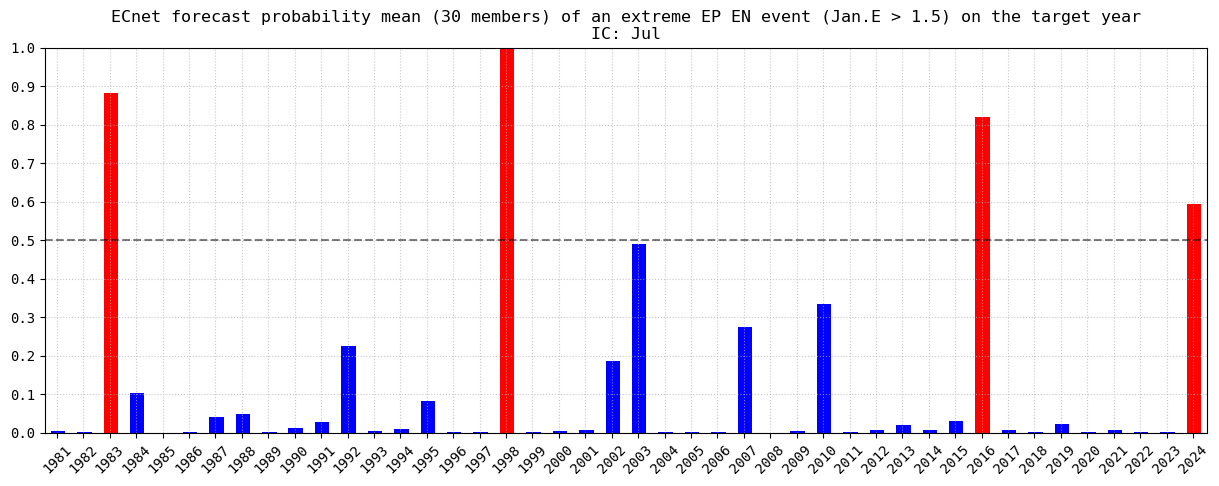

In [12]:
year_locator = mdates.YearLocator(month=month_num, day=1)
year_formatter = mdates.DateFormatter("%Y")

fig, ax = plt.subplots(figsize=(15, 5))
data_sel = model_output_godas.class_hat.sel(
    ic=model_output_godas.ic.dt.month.isin([month_num])
).mean("member")
data_sel["ic"] = pd.to_datetime(data_sel.ic) + pd.DateOffset(years=1)

data_sel_pos = data_sel.where(data_sel > 0.5, drop=True)
data_sel_neg = data_sel.where(data_sel < 0.5, drop=True)

bars = ax.bar(pd.to_datetime(data_sel_pos.ic.data), data_sel_pos.data, 200, color="r")

bars = ax.bar(
    pd.to_datetime(data_sel_neg.ic.data), data_sel_neg.data, 200, color="blue"
)

ax.axhline(0.5, c="k", ls="--", alpha=0.5)

ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim(0, 1)
ax.set_xlim(
    pd.to_datetime(data_sel.ic[0].data) - pd.DateOffset(months=6),
    pd.to_datetime(data_sel.ic[-1].data) + pd.DateOffset(months=6),
)

ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_major_formatter(year_formatter)

ax.tick_params(axis="x", rotation=45)
ax.grid(ls="dotted", alpha=0.7)

ax.set_title(
    "ECnet forecast probability mean (30 members) of an extreme EP EN event (Jan.E > 1.5) on the target year"
    f"\nIC: {pd.to_datetime(f'1995-{month_num}'):%b}"
)

In [13]:
import cartopy.feature as cfeature

SD_BORDER = cfeature.NaturalEarthFeature(
    category="physical",
    name="land",
    scale="50m",
    facecolor="white",
    edgecolor="black",
    linewidth=0.5,
)

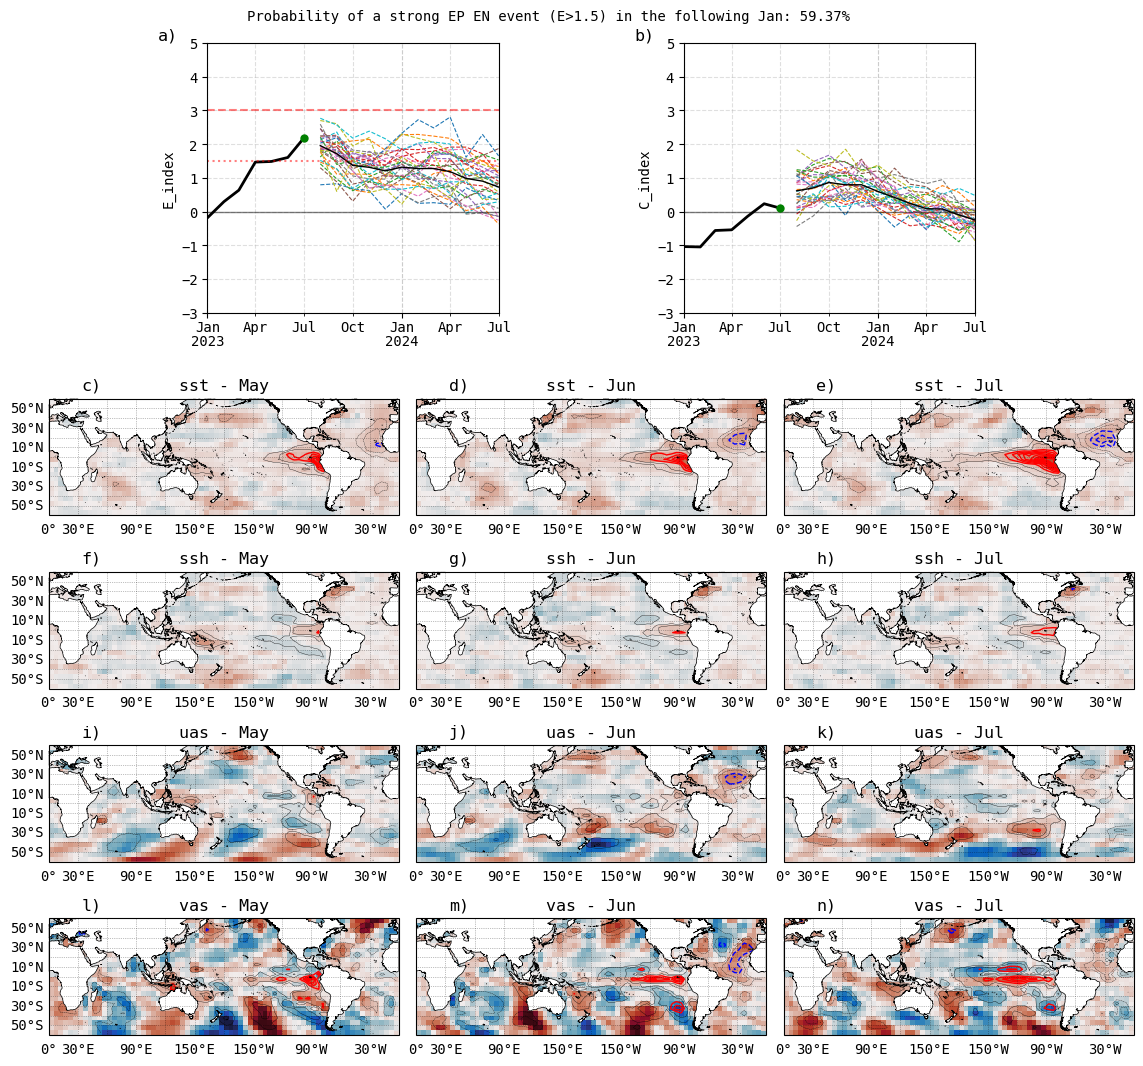

In [17]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

plt.rcParams["font.family"] = "monospace"


month_num = 7
year = 2023
date = f"{year}-{month_num:02d}"

_eplot_data = model_output_godas.eindex.sel(
    ic=model_output_godas.ic.dt.month.isin([month_num])
)
_cplot_data = model_output_godas.cindex.sel(
    ic=model_output_godas.ic.dt.month.isin([month_num])
)

lrp_plot = (LRP_godas * 100).sel(ic=date).squeeze().mean("member")

var_plot = godas_data.sel(ic=date).squeeze()

month_locator = mdates.MonthLocator(bymonth=[1, 4, 7, 10])
month_formatter = mdates.DateFormatter("%b")

year_locator = mdates.YearLocator()
year_formatter = mdates.DateFormatter("%Y")

fig = plt.figure(figsize=(14, 14))

gs = GridSpec(2, 1, height_ratios=[1, 3], figure=fig, hspace=0)

gs0 = GridSpecFromSubplotSpec(1, 7, subplot_spec=gs[0])
# E TS
ax1 = fig.add_subplot(gs0[0, 1:3])
ax1.text(-0.1, 1, "a)", transform=ax1.transAxes, va="bottom", ha="right", size=12)

# C TS
ax2 = fig.add_subplot(gs0[0, 4:6])
ax2.text(-0.1, 1, "b)", transform=ax2.transAxes, va="bottom", ha="right", size=12)

for ax, var, obs, dranges, drawLimit in zip(
    [ax1, ax2],
    [_eplot_data, _cplot_data],
    [godas_label_obs.E_index, godas_label_obs.C_index],
    [(-3, 5), (-3, 5)],
    [True, False],
):
    for _date in var.sel(ic=f"{year}"):
        new_time = pd.date_range(
            pd.to_datetime(_date.ic.data),
            freq="MS",
            periods=12,
        )
        to_plot = _date.assign_coords(lead=new_time)
        to_plot.plot.line(ax=ax, x="lead", ls="--", add_legend=False, lw=0.8)
        to_plot.mean("member").plot(ax=ax, lw=1, c="k")
        ax.set_title("")

    obs.sel(time=slice(None, f"{year}-{month_num}")).plot(ax=ax, lw=2, c="k")
    obs.sel(time=obs.time.dt.month.isin([month_num])).sel(time=f"{year}").plot.scatter(
        ax=ax, c="g", zorder=10, lw=0
    )
    ax.set_title("")
    if drawLimit:
        ax.axhline(y=1.5, ls="dotted", alpha=0.5, c="r", lw=1.5)
        ax.axhline(y=3, ls="--", alpha=0.5, c="r", lw=1.5)
    ax.axhline(y=0, alpha=0.5, c="k", lw=1)

    ax.xaxis.set_minor_locator(month_locator)
    ax.xaxis.set_minor_formatter(month_formatter)
    ax.xaxis.set_major_locator(year_locator)
    ax.xaxis.set_major_formatter(year_formatter)
    ax.xaxis.remove_overlapping_locs = False
    ax.tick_params(axis="x", which="major", pad=12)
    ax.tick_params(axis="x", labelrotation=0)
    for xlabels in ax.get_xticklabels():
        xlabels.set_ha("center")

    ax.grid(which="both", ls="--", alpha=0.4)
    ax.set_xlim(
        pd.to_datetime(f"{year}-01"), pd.to_datetime(f"{year+1}-{month_num:02d}")
    )
    ax.set_ylim(*dranges)
    ax.set_xlabel("")

prob = model_output_godas.class_hat.sel(ic=date).mean("member")
ax.text(
    -1.5,
    1.1,
    f"Probability of a strong EP EN event (E>1.5) in the following Jan: {prob.data[0]:.2%}",
    transform=ax.transAxes,
    va="center",
    ha="left",
)


# MAPS
gs1 = GridSpecFromSubplotSpec(4, 3, subplot_spec=gs[1], wspace=0.05, hspace=-0.4)

# SST
ax3 = fig.add_subplot(gs1[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax4 = fig.add_subplot(gs1[0, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax5 = fig.add_subplot(gs1[0, 2], projection=ccrs.PlateCarree(central_longitude=180))

# SSH
ax6 = fig.add_subplot(gs1[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax7 = fig.add_subplot(gs1[1, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax8 = fig.add_subplot(gs1[1, 2], projection=ccrs.PlateCarree(central_longitude=180))

# UAS
ax9 = fig.add_subplot(gs1[2, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax10 = fig.add_subplot(gs1[2, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax11 = fig.add_subplot(gs1[2, 2], projection=ccrs.PlateCarree(central_longitude=180))

# VAS
ax12 = fig.add_subplot(gs1[3, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax13 = fig.add_subplot(gs1[3, 1], projection=ccrs.PlateCarree(central_longitude=180))
ax14 = fig.add_subplot(gs1[3, 2], projection=ccrs.PlateCarree(central_longitude=180))

axs = [[ax3, ax4, ax5], [ax6, ax7, ax8], [ax9, ax10, ax11], [ax12, ax13, ax14]]

_letters = iter(
    ["c)", "d)", "e)", "f)", "g)", "h)", "i)", "j)", "k)", "l)", "m)", "n)"]
)

for channel, _axs in zip(var_plot.channel, axs):
    for lag, ax in zip(var_plot.lag, _axs):
        ax.text(
            0.15,
            1.05,
            next(_letters),
            transform=ax.transAxes,
            va="bottom",
            ha="right",
            size=12,
        )
        _sel_plot = var_plot.sel(channel=channel, lag=lag)
        _sel_plot.plot(
            ax=ax,
            add_colorbar=False,
            vmax=4.5,
            vmin=-4.5,
            transform=ccrs.PlateCarree(),
            cmap=cmo.cm.balance,
        )

        _sel_lrp_plot = lrp_plot.sel(channel=channel, lag=lag)
        _sel_lrp_plot.plot.contour(
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=[-0.1, -0.05, 0.05, 0.1],
            linewidths=0.25,
            colors="k",
        )
        _sel_lrp_plot.plot.contour(
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=np.arange(0.2, 1.1, 0.1),
            linewidths=1,
            colors="r",
        )
        _sel_lrp_plot.plot.contour(
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=np.arange(-1, -0.1, 0.1),
            linewidths=1,
            colors="b",
        )

        gl = ax.gridlines(
            crs=ccrs.PlateCarree(),
            draw_labels=True,
            xlocs=np.arange(-150, 360, 30),
            ylocs=np.arange(-50, 60, 10),
            x_inline=False,
            y_inline=False,
            linewidth=0.5,
            color="k",
            alpha=0.5,
            ls="dotted",
        )

        gl.top_labels = False
        if lag.data != -2:
            gl.left_labels = False

        _date = pd.to_datetime(_sel_plot.ic.data) - pd.DateOffset(months=abs(lag.data))
        ax.set_title(f"{channel.data} - {_date:%b}")

        ax.add_feature(SD_BORDER, zorder=2)
fig.savefig(
    os.path.join(FIG_FOLDER, f"IGP-UHM_realtime_{date}.pdf"),
    bbox_inches="tight",
    dpi=400,
)
fig.savefig(
    os.path.join(FIG_FOLDER, f"IGP-UHM_realtime_{date}.png"),
    bbox_inches="tight",
    dpi=400,
)

Text(0.5, 1.0, 'ECnet probability for an extreme EN event during Jan 1998')

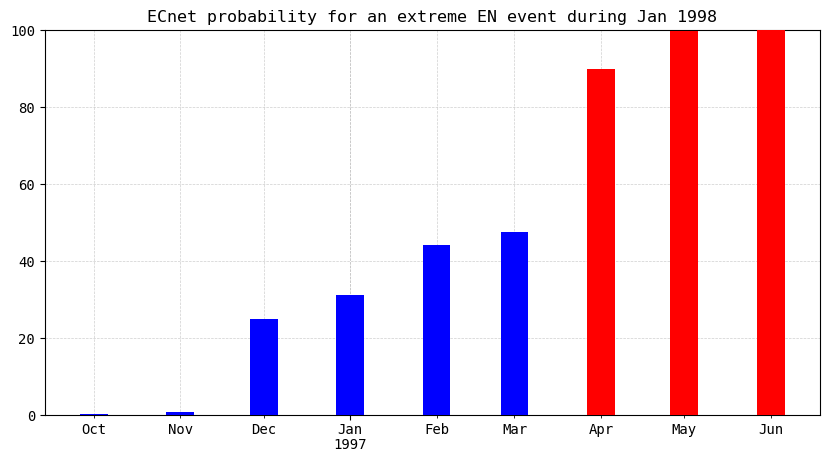

In [86]:
bar_data = (
    model_output_godas.class_hat.mean("member").sel(ic=slice("1996-10", "1997-6")) * 100
)

bar_data_red = bar_data.where(bar_data >= 50)
bar_data_blue = bar_data.where(bar_data < 50)

year_locator = mdates.YearLocator(day=15)
year_formatter = mdates.DateFormatter("%Y")

month_locator = mdates.MonthLocator(bymonthday=15)
month_formatter = mdates.DateFormatter("%b")


fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(
    pd.to_datetime(bar_data_blue.ic.data),
    bar_data_blue.data,
    10,
    color="blue",
    zorder=10,
)
ax.bar(
    pd.to_datetime(bar_data_red.ic.data), bar_data_red.data, 10, color="red", zorder=10
)

ax.xaxis.set_minor_locator(month_locator)
ax.xaxis.set_minor_formatter(month_formatter)
ax.xaxis.set_major_locator(year_locator)
ax.xaxis.set_major_formatter(year_formatter)

ax.xaxis.remove_overlapping_locs = False
ax.tick_params(axis="x", which="major", pad=13)

ax.set_ylim(0, 100)
ax.grid(which="both", ls="--", lw=0.5, alpha=0.6)
ax.set_title("ECnet probability for an extreme EN event during Jan 1998")

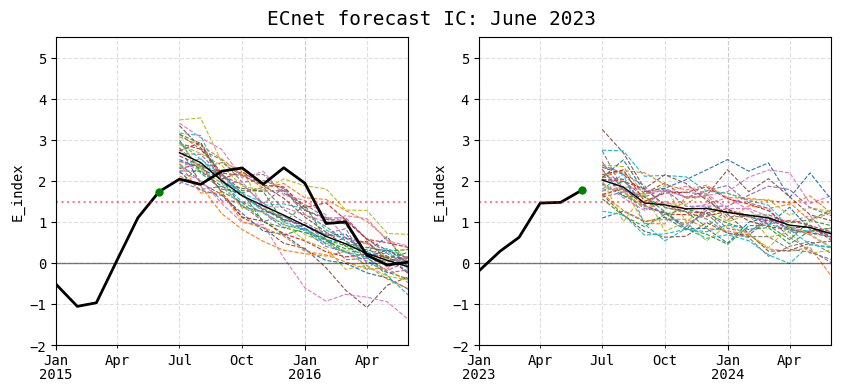

In [183]:
month_num = 6
year = 2023


_eplot_data = model_output_godas.eindex.sel(
    ic=model_output_godas.ic.dt.month.isin([month_num])
)
_cplot_data = model_output_godas.cindex.sel(
    ic=model_output_godas.ic.dt.month.isin([month_num])
)

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

for ax, var, obs, dranges, drawLimit, year in zip(
    axs.flatten(),
    [_eplot_data, _eplot_data],
    [godas_label_obs.E_index, godas_label_obs.E_index],
    [(-2, 5.5), (-2, 5.5)],
    [True, True],
    [2015, 2023],
):
    for _date in var.sel(ic=f"{year}"):
        new_time = pd.date_range(
            pd.to_datetime(_date.ic.data),
            freq="MS",
            periods=12,
        )
        to_plot = _date.assign_coords(lead=new_time)
        to_plot.plot.line(ax=ax, x="lead", ls="--", add_legend=False, lw=0.8)
        to_plot.mean("member").plot(ax=ax, lw=1, c="k")
        ax.set_title("")

    obs.plot(ax=ax, lw=2, c="k")
    obs.sel(time=obs.time.dt.month.isin([month_num])).sel(time=f"{year}").plot.scatter(
        ax=ax, c="g", zorder=10, lw=0
    )
    ax.set_title("")
    if drawLimit:
        ax.axhline(y=1.5, ls="dotted", alpha=0.5, c="r", lw=1.5)
    ax.axhline(y=0, alpha=0.5, c="k", lw=1)
    month_locator = mdates.MonthLocator(bymonth=[1, 4, 7, 10])
    month_formatter = mdates.DateFormatter("%b")

    year_locator = mdates.YearLocator()
    year_formatter = mdates.DateFormatter("%Y")

    ax.xaxis.set_minor_locator(month_locator)
    ax.xaxis.set_minor_formatter(month_formatter)
    ax.xaxis.set_major_locator(year_locator)
    ax.xaxis.set_major_formatter(year_formatter)
    ax.xaxis.remove_overlapping_locs = False
    ax.tick_params(axis="x", which="major", pad=12)
    ax.tick_params(axis="x", labelrotation=0)
    for xlabels in ax.get_xticklabels():
        xlabels.set_ha("center")

    ax.grid(which="both", ls="--", alpha=0.4)
    ax.set_xlim(pd.to_datetime(f"{year}-01"), pd.to_datetime(f"{year+1}-06"))
    ax.set_ylim(*dranges)
    ax.set_xlabel("")
pd_date = pd.to_datetime(_eplot_data[0].ic.data)
fig.suptitle(
    f"ECnet forecast IC: {pd_date:%B} {year}",
    y=0.95,
    fontsize=14,
)
# fig.savefig(f"ts_ecnet_ic{year}.{month_num:02d}.png", dpi=500, bbox_inches="tight")